#Table of Contents
* [Imports & definitions](#Imports-&-definitions)
* [Define functions and classes to calculate and plot rays](#Define-functions-and-classes-to-calculate-and-plot-rays)


In [1]:
%%javascript
IPython.load_extensions('calico-document-tools');

<IPython.core.display.Javascript object>

# Imports & definitions

In [1]:
# Main imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
from __future__ import division
from __future__ import print_function

# Needed for LineCollections helper functions
from matplotlib.collections import LineCollection

# Angle unit conversion
degtorad = np.pi/180.

# Define functions and classes to calculate and plot rays

In [2]:
#--------------------------------------------------------------------
# Utility Functions
#--------------------------------------------------------------------

def theta2_from_Snells_law(angle1, n1, n2):
    return np.arcsin(np.sin(angle1) * n1 / n2)

def reflectance_TE(angle1, n1, n2):
    angle2 = theta2_from_Snells_law(angle1, n1, n2)
    temp = n1*np.cos(angle1) - n2*np.cos(angle2)
    temp = temp / (n1*np.cos(angle1) + n2*np.cos(angle2))
    return temp**2

def transmittance_TE(angle1, n1, n2):
    return 1.0 - reflectance_TE(angle1, n1, n2)

def reflectance_TM(angle1, n1, n2):
    angle2 = theta2_from_Snells_law(angle1, n1, n2)
    temp = n1*np.cos(angle2) - n2*np.cos(angle1)
    temp = temp / (n1*np.cos(angle2) + n2*np.cos(angle1))
    return temp**2

def transmittance_TM(angle1, n1, n2):
    return 1.0 - reflectance_TM(angle1, n1, n2)

def reflectance_Unpol(angle1, n1, n2):
    rTE = reflectance_TE(angle1, n1, n2)
    rTM = reflectance_TM(angle1, n1, n2)
    return 0.5 * (rTE + rTM)

def transmittance_Unpol(angle1, n1, n2):
    return 1.0 - reflectance_Unpol(angle1, n1, n2)


#--------------------------------------------------------------------
# Main computational class for general rays
#--------------------------------------------------------------------

class rayThroughPlanarInterfaces():
    
    def __init__(self, ray_dist_from_axis=0.0, angle_rad=0.0, refr_index=1.0, start_location_on_axis=0.0):
        self.h = np.array([ray_dist_from_axis])
        self.ang_rad = np.array([angle_rad])
        self.refr_index = np.array([refr_index])
        self.location_on_axis = np.array([start_location_on_axis])
        self.normpower_in_rayTE = np.array([1.0])
        self.normpower_in_rayTM = np.array([1.0])
        self.normpower_in_rayUnpol = np.array([1.0])
        
    def propagate_to_and_thru_new_surface(self,l,new_refr_index):
        self.normpower_in_rayTE = np.append(self.normpower_in_rayTE, 
                                          self.normpower_in_rayTE[-1] * 
                                          transmittance_TE(self.ang_rad[-1],self.refr_index[-1],new_refr_index))
        self.normpower_in_rayTM = np.append(self.normpower_in_rayTM, 
                                          self.normpower_in_rayTM[-1] * 
                                          transmittance_TM(self.ang_rad[-1],self.refr_index[-1],new_refr_index))
        self.normpower_in_rayUnpol = 0.5 * (self.normpower_in_rayTE[-1] + self.normpower_in_rayTM[-1])
        self.location_on_axis = np.append(self.location_on_axis, self.location_on_axis[-1] + l)
        delta_h = l*np.tan(self.ang_rad[-1])
        self.h = np.append(self.h, self.h[-1] + delta_h)
        new_angle = np.arcsin(np.sin(self.ang_rad[-1])*self.refr_index[-1]/new_refr_index)
        self.ang_rad = np.append(self.ang_rad, new_angle)
        self.refr_index = np.append(self.refr_index, new_refr_index)
        
    def print_values(self):
        print('location_on_axis', 'h', 'ang_rad', 'refr_index', 'normalized power')
        print(self.location_on_axis, self.h, self.ang_rad, self.refr_index)
        print(self.normpower_in_rayTE, self.normpower_in_rayTM, self.normpower_in_rayUnpol)

        
#--------------------------------------------------------------------
# Helper functions to make a LineCollection
#   Topics: line, color, LineCollection, cmap, colorline, codex
#   From: http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
#--------------------------------------------------------------------

'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''

# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(ax, x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    #ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

In [3]:
thicknesses = np.array([0.01, 7.7, 4.0])
refractive_indices = np.array([1.46, 3.6, 3.6])
initial_refr_index = 1.33
start_location_on_axis = 0.0
array_of_rays = []
for i, angle in enumerate(range(-85,90,5)):
    array_of_rays.append(rayThroughPlanarInterfaces(ray_dist_from_axis = 0.0, 
                                                    angle_rad = angle*degtorad, 
                                                    refr_index = initial_refr_index, 
                                                    start_location_on_axis = start_location_on_axis))
    for l,n in zip(thicknesses, refractive_indices):
        array_of_rays[i].propagate_to_and_thru_new_surface(l, n)

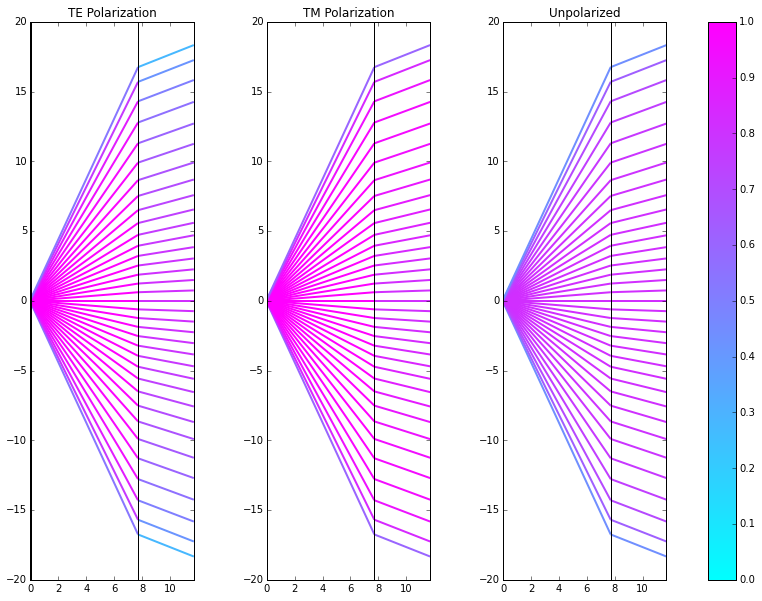

In [5]:
ylimit = 20
fig, axes = plt.subplots(1,3,figsize = (15,10))
for ax in axes:
    ax.set_aspect('equal')
    ax.set_ylim(-ylimit,ylimit)
    ax.set_xlim(0, array_of_rays[0].location_on_axis[-1])
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap._A = [] #see http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plotsa

# Plot rays
for ray in array_of_rays:
    colorline(axes[0], x=ray.location_on_axis, y=ray.h, z=ray.normpower_in_rayTE, cmap=cmap, norm=cNorm, linewidth=2.0)
    colorline(axes[1], x=ray.location_on_axis, y=ray.h, z=ray.normpower_in_rayTM, cmap=cmap, norm=cNorm, linewidth=2.0)
    colorline(axes[2], x=ray.location_on_axis, y=ray.h, z=ray.normpower_in_rayUnpol, cmap=cmap, norm=cNorm, linewidth=2.0)

# Make vertical lines to indicate position of planar interfaces
for ax in axes:
    for x in array_of_rays[0].location_on_axis:
        ax.vlines(x,-ylimit,ylimit)
        ax.vlines(x,-ylimit,ylimit)
        
# Set plot titles
axes[0].set_title('TE Polarization')
axes[1].set_title('TM Polarization')
axes[2].set_title('Unpolarized')

# Plot the colormap, see 3rd answer at http://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
fig.colorbar(scalarMap, ax=axes.ravel().tolist());